# Question 2:

**Company XYZ is a major credit card company. They have found that their existing fraud detection system is slow to recognize new 
patterns of fraud and is costing them lots of money. They have contracted Deloitte to implement an algorithm that returns all 
transactions that seem unusual and are worth being investigated further. They have provided two tables: Table “cc_info” which
contains general information about the credit card and its holder, and “transactions” which contains information about each 
transaction that happened between August 1st and October 30th for credit cards in the cc_info table. Your task is to design and
implement a neural-network based solution that will return all transactions that seem to be fraudulent and require further 
investigation.**

# Background

Credit Card Fraud has been an ever growing issue impacting the financial losses, trust and credibility.

AI based credit card fraud detection play a vital role in flagging a transaction as fradulent or non-fradulent. 

**AI based credit card fraud vs Rule-based system :**

AI based credit card fraud detection helps in detecting fraud automatically resulting in real-time streaming.
Rule-Based System will require enormous amount of time in making decisions in determining schemes.

AI based credit card fraud detection takes less time compared to rule-based system for verification methods by identifying hidden correlations in data. Rule-based system needs multiple verification methods which consumes lot of time leading inconvenience for the user.

# Dataset Overview

There are two tables given.
1. cc_info.csv containing general information about the credit card and its holder. 
General information includes - <br/>
    a. credit card number <br/>
    b. city <br/>
    c. state <br/>
    d. zip code <br/>
    e. credit card limit <br/> <br/>
    
2. transactions.csv containing information about each transaction that happened between August 1st and October 30th for credit cards in the cc_info table. 
Transaction information includes - <br/>
    a. credit card number <br/>
    b. date <br/>
    c. transactions in dollars <br/>
    d. Longitude <br/>
    e. Latitude <br/> <br/>

The dataset do not contain explicit labels as fradulent or non-fradulent transactions. 

# Proposed Solution

**Supervised Learning**<br/>
If the dataset had come with labels stating whether a transaction is fradulent or non-fradulent, then the problem could be addressed with the supervised machine learning algorithms / deep learning techniques like - <br/>
1. Random Forest Classifier, SVM Classifier, Logistic Regression, KNN Classifier etc
2. Boosting Algorithms - AdaBoost, Xgboost, GBDT etc
3. Artificial Neural Network

In this case, the dataset can be heavily imbalanced due to number of frauds is being smaller compared to normal transactions. The dataset has to be balanced using techniques like undersampling, oversampling, SMOTE before training the model.

**Unsupervised Learning**<br/>
Labelling millions of transactions and detecting the features to characterize frauds or normal is very difficult task and also since the dataset do not contain labels, the problem is to be approached using unsupervised learning methods.
1. Since manual labelling of the data is time consuming and expensive, we can use clustering technique. After getting the clusters, we can pick few points from each clusters and label each cluster as unique class by reviewing the points picked.
2. Unsupervised algorithms like Local Outlier Factor, Isolation Forest can be used in identifying fradulent and normal transactions.
3. Identifying fradulent and non-fradulent transactions using Auto-encoders - Unsupervised based neural network architecture. 

<h3>In this notebook, the problem of identifying fradulent and non-fradulent transactions with Auto-Encoders has been demonstrated.<h3>

# Importing Libraries

In [2]:
# importing libraries
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from geopy.geocoders import Nominatim
import datetime
import os

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

# EDA

**Reading the tables - cc_info.csv & transaction.csv**

In [3]:
# reading the cc_info.csv file
cc_info = pd.read_csv("cc_info.csv")
# reading transactions.csv file
transactions = pd.read_csv("transactions.csv")

**Visualizing cc_info table**

In [4]:
# displaying first 5 rows of the cc_info data 
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


**Visualizing transactions table**

In [5]:
# displaying first 5 rows of the transactions data 
transactions.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


**Combining cc_info and transactions table based on credit card details**

In [6]:
# combining the two files on the column credit_card
data = pd.merge(cc_info, transactions, on='credit_card')

**Visualizing combined data**

In [6]:
# displaying first 5 rows of the combined data
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


**Size of the Dataset**

In [7]:
print("Total Number of Transactions is", data.shape[0])

Total Number of Transactions is 294588


**Total Number of Unique Card Holders in the given Dataset**

In [8]:
print("Total Number of Credit Card Holders is", data["credit_card"].unique().shape[0])

Total Number of Credit Card Holders is 984


**Generate descriptive statistics**

In [9]:
data[["credit_card_limit","transaction_dollar_amount"]].describe()

,credit_card_limit,transaction_dollar_amount
count,294588.000000,294588.000000
mean,15502.053716,86.008036
std,7956.291556,124.655954
min,2000.000000,0.010000
25%,10000.000000,29.970000
50%,15000.000000,58.470000
75%,20000.000000,100.400000
max,55000.000000,999.970000


**Observations**
1. There are totally 294588 records in our data.
2. The cental tendency of the data in "transaction_dollar_amount" is smaller compared to "credit_card_limit".
3. Standard deviation of the "credit_card_limit" is higher compared to "transaction_dollar_amount" and hence feature "credit_card_limit" has greater spread of the data, exhibiting more variation compared to "transaction_dollar_amount".
4. The minimum credit card limit in the given data is 2000 and maximum credit card limit is 55000 (in dollars).
5. The minimum transaction amount is 0 and maximum is 999.97 (in dollars).
6. For feature "credit_card_limit", <br/>
    a. 25% of the credit card limit is below 10000 dollars (minimum is 2000 dollars and maximum is 10000 dollars). <br/>
    b. 50% of the credit card limit is below 15000 dollars (minimum is 2000 dollars and maximum is 15000 dollars). <br/>
    c. 75% of the credit card limit is below 20000 dollars (minimum is 2000 dollars and maximum is 20000 dollars). <br/>
7. For feature "transaction_dollar_amount", <br/>
    a. 25% of the transaction is below 29.97 dollars (minimum is 0.01 dollars and maximum is 29.97 dollars). <br/>
    b. 50% of the transaction is below 58.47 dollars (minimum is 0.01 dollars and maximum is 58.47 dollars). <br/>
    c. 75% of the transaction is below 100 dollars (minimum is 0.01 dollars and maximum is 100 dollars). <br/>


**Concise Summary of the Dataframe**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   city                       294588 non-null  object 
 2   state                      294588 non-null  object 
 3   zipcode                    294588 non-null  int64  
 4   credit_card_limit          294588 non-null  int64  
 5   date                       294588 non-null  object 
 6   transaction_dollar_amount  294588 non-null  float64
 7   Long                       294588 non-null  float64
 8   Lat                        294588 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.5+ MB


**Observations**
1. All the features in our dataset do not hold missing values.
2. Data type of date feature is of type object. We need to convert the data type of feature date to datetime.

**Conerting data type of feature date to datetime from object**

In [11]:
data['date'] = pd.to_datetime(data['date'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   city                       294588 non-null  object        
 2   state                      294588 non-null  object        
 3   zipcode                    294588 non-null  int64         
 4   credit_card_limit          294588 non-null  int64         
 5   date                       294588 non-null  datetime64[ns]
 6   transaction_dollar_amount  294588 non-null  float64       
 7   Long                       294588 non-null  float64       
 8   Lat                        294588 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 22.5+ MB


**Observations**
1. Data type of feature date is now of type datetime.

**Credit card transactions - Time density plot**

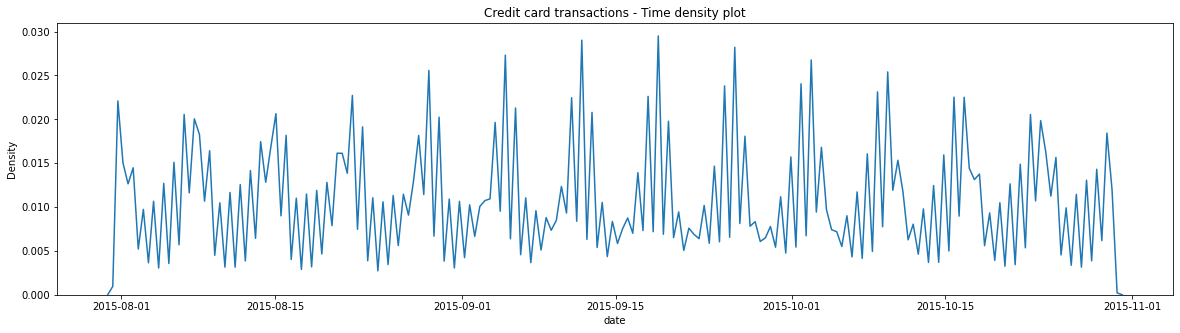

In [13]:
# time distribution
plt.figure(figsize = (20,5))
sns.kdeplot(data['date'], x="date", bw_adjust=.10)
plt.title("Credit card transactions - Time density plot")
plt.show()

**Observation**
1. Between 1st September 2015 and 1st October 2015, there has been highest concentration of transactions.

**Credit card transactions - Transaction amount density plot**

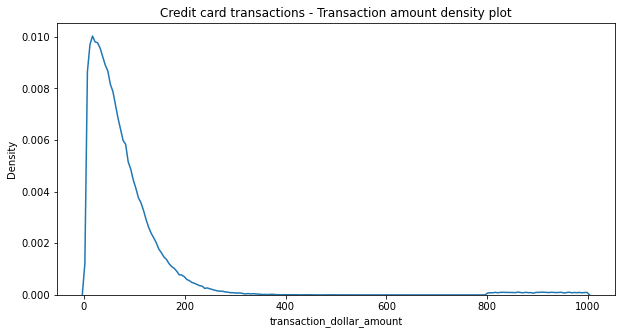

In [14]:
# amount distribution
plt.figure(figsize = (10,5))
sns.kdeplot(data['transaction_dollar_amount'], x="transaction_amount($)", bw_adjust=.10)
plt.title("Credit card transactions - Transaction amount density plot")
plt.show()

**Observation**
1. There is highest concentraction of transaction amount between 0 to 300 dollars.

**Maximum & Minimum transactions made by credit cards**

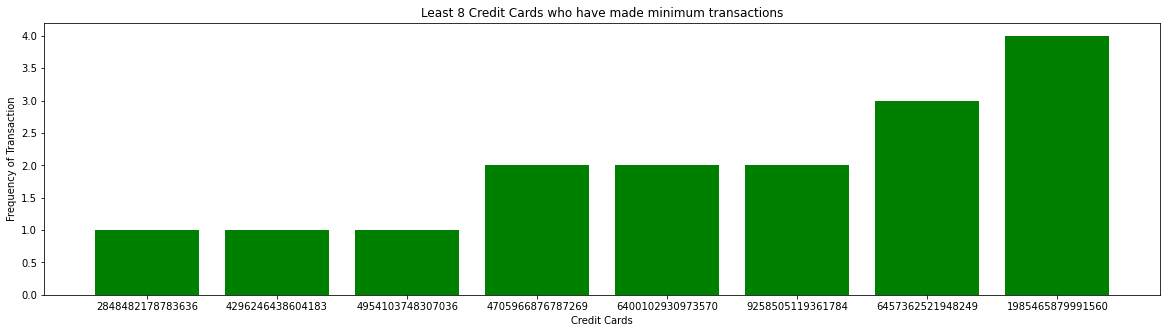

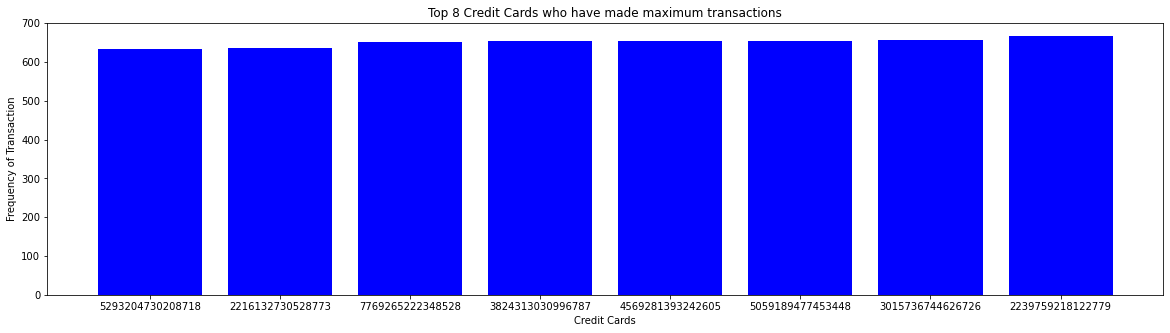

In [15]:
# creating dictionary that holds credit card number as key and the frequency of transactions as value
unique_labels, labels_counts = np.unique(data["credit_card"].values, return_counts=True)
label_stats = dict(zip(unique_labels, labels_counts))
sorted_label_stats = dict(sorted(label_stats.items(), key=lambda item: item[1]))

# considering least 8 credit cards whose frequency is minimum
least_8_cards = {str(k): sorted_label_stats[k] for k in list(sorted_label_stats)[:8]}
#print("Least 10 credit cards who have made minimum transactions",least_10_cards)

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(least_8_cards.keys()), list(least_8_cards.values()), color ='green')
 
plt.xlabel("Credit Cards")
plt.ylabel("Frequency of Transaction")
plt.title("Least 8 Credit Cards who have made minimum transactions")
plt.show()

# considering top 8 credit cards whose frequency is maximum
top_10_cards = {str(k): sorted_label_stats[k] for k in list(sorted_label_stats)[-8:]}
#print("Top 10 credit cards who have made maximum transactions",top_10_cards)

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(top_10_cards.keys()), list(top_10_cards.values()), color ='blue')
 
plt.xlabel("Credit Cards")
plt.ylabel("Frequency of Transaction")
plt.title("Top 8 Credit Cards who have made maximum transactions")
plt.show()

**Observations**
1. Refering to figure 1 - 3636, 4183, 7036(last 4 digits of credit card number) and so on & so forth has the least number of transactions.
2. Refering to figure 2 - 2779, 6726, 3448(last 4 digits of credit card number) and so on & so forth has the maximum number of transactions.

**Cities holding highest and lowest credit card holders**

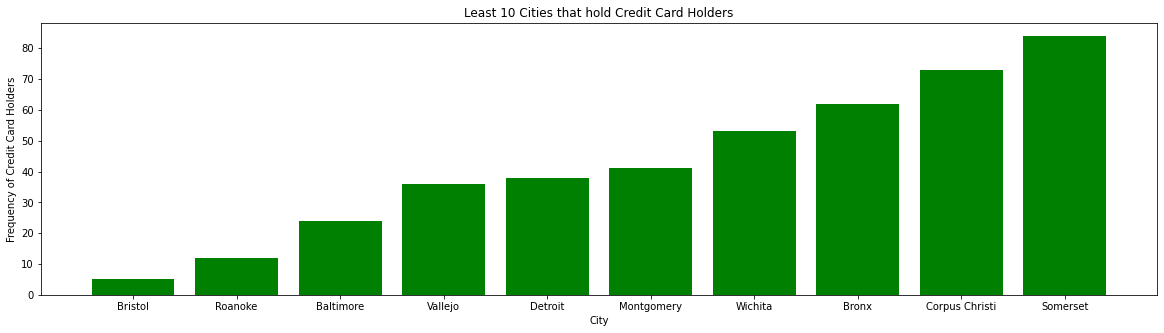

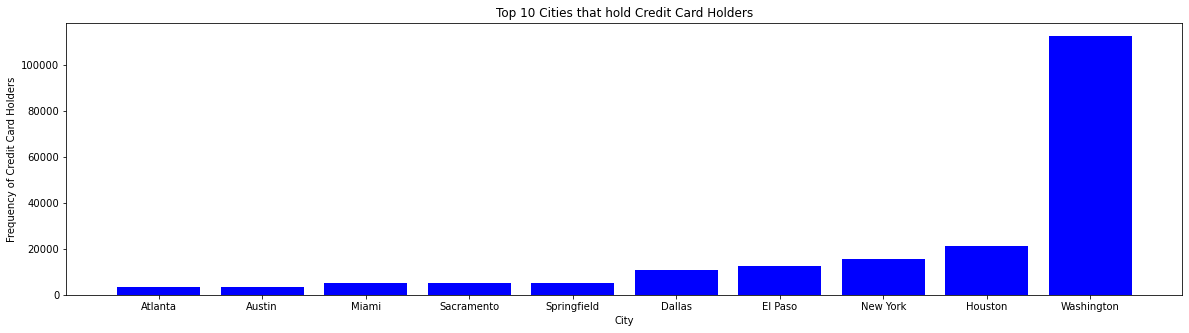

In [7]:
temp_df = data.groupby(['city']).agg({"credit_card":['count']}).reset_index()
temp_df.columns = ["city", "credit_card_count"]
city_list = list(temp_df["city"])
count_list = list(temp_df["credit_card_count"])
city_credit_count = dict(zip(city_list, count_list))
sorted_city_credit_count = dict(sorted(city_credit_count.items(), key=lambda item: item[1]))

# considering least 10 city having minimum credit card holders
least_10_city = {k: sorted_city_credit_count[k] for k in list(sorted_city_credit_count)[:10]}

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(least_10_city.keys()), list(least_10_city.values()), color ='green')
 
plt.xlabel("City")
plt.ylabel("Frequency of Credit Card Holders")
plt.title("Least 10 Cities that hold Credit Card Holders")
plt.show()

# considering Top 10 cities having maximum credit card holders
top_10_city = {k: sorted_city_credit_count[k] for k in list(sorted_city_credit_count)[-10:]}

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(top_10_city.keys()), list(top_10_city.values()), color ='blue')
 
plt.xlabel("City")
plt.ylabel("Frequency of Credit Card Holders")
plt.title("Top 10 Cities that hold Credit Card Holders")
plt.show()

**Observations**
1. Refering to figure 1 - cities Bristol, Roanoke, Baltimore, Vallejo and so on - so forth are the cities which has least number of credit card holders.
2. Refering to figure 2 - cities washington has the highest credit card holders, followed by Houston and then new york and so on.

**Cities holding highest and lowest transactions made**

ERROR! Session/line number was not unique in database. History logging moved to new session 294


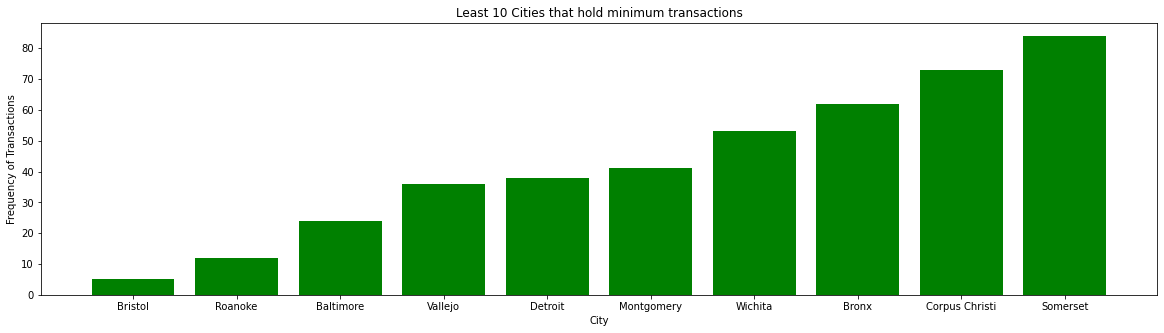

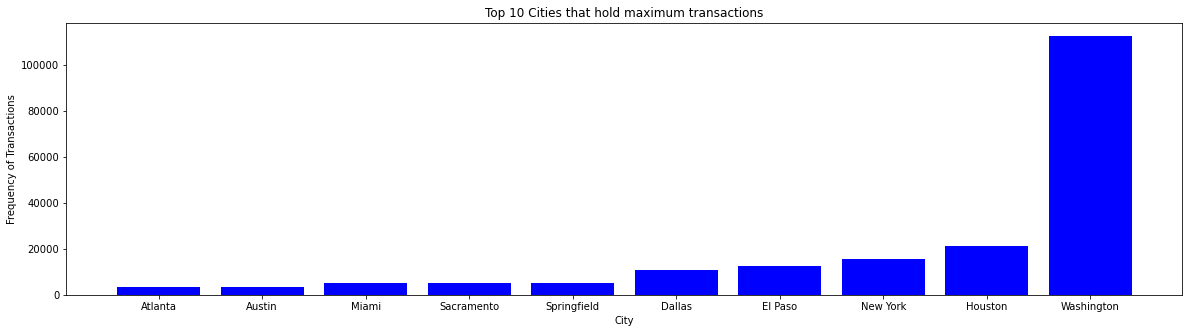

In [16]:
city_counts = dict(data["city"].value_counts())
sorted_city_counts = dict(sorted(city_counts.items(), key=lambda item: item[1]))
# considering least 10 city having minimum transactions
least_10_city = {k: sorted_city_counts[k] for k in list(sorted_city_counts)[:10]}

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(least_10_city.keys()), list(least_10_city.values()), color ='green')
 
plt.xlabel("City")
plt.ylabel("Frequency of Transactions")
plt.title("Least 10 Cities that hold minimum transactions")
plt.show()

# considering Top 10 cities having maximum credit card holders
top_10_city = {k: sorted_city_counts[k] for k in list(sorted_city_counts)[-10:]}

# plotting
fig = plt.figure(figsize = (20, 5))
plt.bar(list(top_10_city.keys()), list(top_10_city.values()), color ='blue')
 
plt.xlabel("City")
plt.ylabel("Frequency of Transactions")
plt.title("Top 10 Cities that hold maximum transactions")
plt.show()

**Observations**
1. Refering to figure 1 - cities Bristol, Roanoke, Baltimore, Vallejo and so on - so forth are the cities which has least number of transactions.
2. Refering to figure 2 - cities washington has the highest transactions, folloed by Houston and then new york and so on.

**Scatter Plot for Time - Transaction Amount**

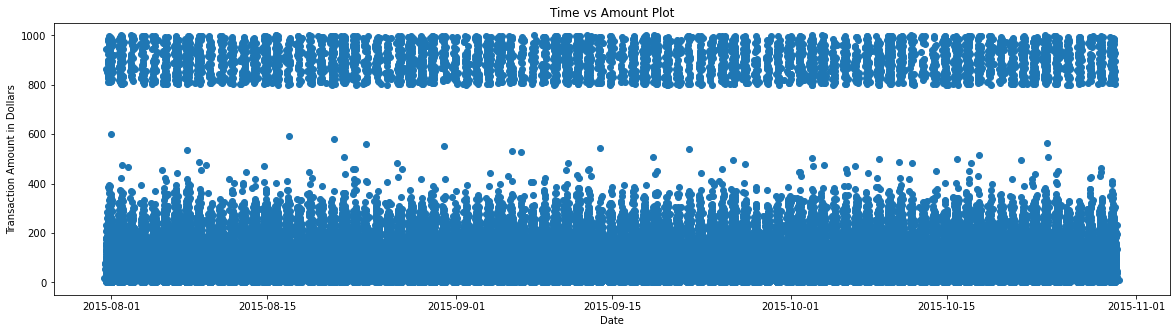

In [17]:
# scatter plot - time vs amount
fig = plt.figure(figsize = (20, 5))
plt.scatter(data["date"].values, data["transaction_dollar_amount"])
plt.xlabel("Date")
plt.ylabel("Transaction Amount in Dollars")
plt.title("Time vs Amount Plot")
plt.show()

# Feature Engineering

**Steps**
1. Using zipcode, getting the corresponding longitude and latitude. Distance between longitude and latitude of transaction and city is found and this distance is used as feature.
2. Average transaction per credit card is calculated and used as feature.
3. From date feature, hour is extracted and binned as Early Morning, Morning, Noon, Evening, Night, Late Night and used as feature.
4. credit_card_limit, transaction_dollar_amount, long_lat_distance, average_transactions, transaction_period are the features used for modelling.
5. Applying One Hot encoder for Categorical column transaction_period and MinMaxScaler for Numerical features.

In [18]:
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


**Using zipcode, getting the corresponding longitude and latitude**

In [19]:
unique_city = list(set(list(data["city"])))
print("Unique Cities in our data is",len(unique_city))

Unique Cities in our data is 124


In [20]:
# extracting longitute and latitude for each city
city_long_latitude = {}
geolocator = Nominatim(user_agent="Your_Name")
for city in tqdm(unique_city):
    address = str(city)
    location = geolocator.geocode(address)
    city_long_latitude[city] = [location.longitude, location.latitude]

data["City_Long_Lat"] = data["city"].apply(lambda row: city_long_latitude.get(row))
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:03<00:00,  1.97it/s]


,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,City_Long_Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,"[-96.7968559, 32.7762719]"
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,"[-96.7968559, 32.7762719]"
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,"[-96.7968559, 32.7762719]"
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,"[-96.7968559, 32.7762719]"
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,"[-96.7968559, 32.7762719]"


In [21]:
# creating temporary dataframe and spliting City_Long_Lat into two separate columns - 'city_longitude','city_latitude'
temp_df = pd.DataFrame(data['City_Long_Lat'].to_list(), columns=['city_longitude','city_latitude'])
# drop city_long_lat column
data = data.drop("City_Long_Lat",axis=1)
# combining temporary df having two columns with our original data
data = pd.concat([data, temp_df], axis=1)
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,city_longitude,city_latitude
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,-96.796856,32.776272
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,-96.796856,32.776272
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,-96.796856,32.776272
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,-96.796856,32.776272
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,-96.796856,32.776272


**Feature - Distance between longitude and latitude of transaction and city**

In [22]:
# distance
def distance(row):
    px = row["Long"]
    py = row["Lat"]
    qx = row["city_longitude"]
    qy = row["city_latitude"]
    dist = math.sqrt((px - qx)**2 + (py - qy)**2)
    return dist
    
data["long_lat_distance"] =  data.apply(lambda row: distance(row), axis=1)
data['dates'] = pd.to_datetime(data['date']).dt.date
data['time'] = pd.to_datetime(data['date']).dt.time
data['week'] = data['date'].dt.week
#data = data.drop("date",axis=1)
data.head()

C:\Users\Smitha Kannur\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,city_longitude,city_latitude,long_lat_distance,dates,time,week
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,-96.796856,32.776272,22.529007,2015-08-05,00:59:19,32
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,-96.796856,32.776272,22.461960,2015-10-29,18:23:04,44
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,-96.796856,32.776272,22.432627,2015-10-25,17:50:48,43
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,-96.796856,32.776272,22.537721,2015-09-05,17:39:43,36
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,-96.796856,32.776272,22.498179,2015-09-04,14:12:59,36


**Feature - Average transaction per credit card**

In [23]:
temp_df = data.groupby(['credit_card']).agg({"transaction_dollar_amount":['mean']}).reset_index()
temp_df.columns = ["credit_card", "average_transactions"]
data = pd.merge(data, temp_df, on='credit_card')
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,city_longitude,city_latitude,long_lat_distance,dates,time,week,average_transactions
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,-96.796856,32.776272,22.529007,2015-08-05,00:59:19,32,53.062943
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,-96.796856,32.776272,22.461960,2015-10-29,18:23:04,44,53.062943
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,-96.796856,32.776272,22.432627,2015-10-25,17:50:48,43,53.062943
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,-96.796856,32.776272,22.537721,2015-09-05,17:39:43,36,53.062943
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,-96.796856,32.776272,22.498179,2015-09-04,14:12:59,36,53.062943


**Feature - Binning Time as Early Morning, Morning, Noon, Evening, Night, Late Night**

In [24]:
def classify_hour(row):
    x = int(row)
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return 'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return 'Night'
    elif (x <= 4):
        return 'Late Night'

data['hour'] = data['date'].dt.hour
data["transaction_period"] = data["hour"].apply(lambda row: classify_hour(row))
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,city_longitude,city_latitude,long_lat_distance,dates,time,week,average_transactions,hour,transaction_period
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,-96.796856,32.776272,22.529007,2015-08-05,00:59:19,32,53.062943,0,Late Night
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,-96.796856,32.776272,22.461960,2015-10-29,18:23:04,44,53.062943,18,Evening
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,-96.796856,32.776272,22.432627,2015-10-25,17:50:48,43,53.062943,17,Evening
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,-96.796856,32.776272,22.537721,2015-09-05,17:39:43,36,53.062943,17,Evening
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,-96.796856,32.776272,22.498179,2015-09-04,14:12:59,36,53.062943,14,Noon


In [25]:
# original dataset
#data.head()

**Dropping columns by keeping features necessary to train model**

In [26]:
# features extracted for model building
model_data =  data.copy()
columns_drop = ["credit_card", "city", "state", "zipcode", "date", "Long", "Lat", "city_longitude", "city_latitude", "dates", "time", "week", "hour"]
model_data = model_data.drop(columns_drop, axis=1)
model_data.head()

,credit_card_limit,transaction_dollar_amount,long_lat_distance,average_transactions,transaction_period
0,6000,11.94,22.529007,53.062943,Late Night
1,6000,5.76,22.461960,53.062943,Evening
2,6000,25.84,22.432627,53.062943,Evening
3,6000,68.89,22.537721,53.062943,Evening
4,6000,27.01,22.498179,53.062943,Noon


**Applying One Hot encoder for Categorical column transaction_period**

In [27]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(model_data[['transaction_period']]).toarray())
enc_df.columns = enc.get_feature_names(['transaction_period'])
model_data = model_data.join(enc_df)
model_data = model_data.drop("transaction_period",axis=1)
model_data.head()

,credit_card_limit,transaction_dollar_amount,long_lat_distance,average_transactions,transaction_period_Early Morning,transaction_period_Evening,transaction_period_Late Night,transaction_period_Morning,transaction_period_Night,transaction_period_Noon
0,6000,11.94,22.529007,53.062943,0.0,0.0,1.0,0.0,0.0,0.0
1,6000,5.76,22.461960,53.062943,0.0,1.0,0.0,0.0,0.0,0.0
2,6000,25.84,22.432627,53.062943,0.0,1.0,0.0,0.0,0.0,0.0
3,6000,68.89,22.537721,53.062943,0.0,1.0,0.0,0.0,0.0,0.0
4,6000,27.01,22.498179,53.062943,0.0,0.0,0.0,0.0,0.0,1.0


**Applying MinMaxScaler (Standardizing data) for Numerical features.**

In [28]:
scaled_columns = ['credit_card_limit', 'transaction_dollar_amount', "long_lat_distance", "average_transactions"]
scaler = MinMaxScaler()
model_data[scaled_columns] = scaler.fit_transform(model_data[scaled_columns])
model_data.head()

,credit_card_limit,transaction_dollar_amount,long_lat_distance,average_transactions,transaction_period_Early Morning,transaction_period_Evening,transaction_period_Late Night,transaction_period_Morning,transaction_period_Night,transaction_period_Noon
0,0.075472,0.011930,0.068594,0.184868,0.0,0.0,1.0,0.0,0.0,0.0
1,0.075472,0.005750,0.068389,0.184868,0.0,1.0,0.0,0.0,0.0,0.0
2,0.075472,0.025831,0.068300,0.184868,0.0,1.0,0.0,0.0,0.0,0.0
3,0.075472,0.068883,0.068620,0.184868,0.0,1.0,0.0,0.0,0.0,0.0
4,0.075472,0.027001,0.068500,0.184868,0.0,0.0,0.0,0.0,0.0,1.0


# Train Test Split

Distribution of the dataset -
1. Total Dataset Shape = 294588 rows and 9 columns
2. Train Set Shape = 206211 rows and 9 columns
3. Validation set shape = 79539 rows and 9 columns
4. Test set shape = 8838 rows and 9 columns

In [29]:
x_train, x_val = train_test_split(model_data, test_size=0.30, random_state=42)
x_val, x_test = train_test_split(x_val, test_size=0.10, random_state=42)

In [30]:
print("Total dataset shape", model_data.shape)
print("Training set shape", x_train.shape)
print("Validation set shape", x_val.shape)
print("Test set shape", x_test.shape)

Total dataset shape (294588, 10)
Training set shape (206211, 10)
Validation set shape (79539, 10)
Test set shape (8838, 10)


In [31]:
import joblib
joblib.dump(x_train, "x_train.pkl")
joblib.dump(x_val, "x_val.pkl")
joblib.dump(x_test, "x_test.pkl")

['x_test.pkl']

# Model Architecture

**Model Config**

In [33]:
input_dim = x_train.shape[1]
BATCH_SIZE = 32
EPOCHS = 5

**Architecture**

In [34]:
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

**Defining Optimizer, loss and metrics**

In [35]:
autoencoder.compile(optimizer="adam", loss="mse", metrics=["acc"])

**Overview of the model**

In [36]:
# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 382
Trainable params: 382
Non-trainable params: 0
_________________________________________________________________


**Defining callbacks - Model Checkpoint, Tensorboard and Early Stopping**

In [39]:
checkpoint = ModelCheckpoint("./model_checkpoint/autoencoder_model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='max')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir,histogram_freq=0, write_graph=True,write_grads=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=10)

callbacks_list = [es, checkpoint, tensorboard_callback]

ERROR! Session/line number was not unique in database. History logging moved to new session 296


In [40]:
history = autoencoder.fit(
    x_train, x_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    validation_data=(x_val, x_val)
);

Train on 206211 samples, validate on 79539 samples
Epoch 1/10
204864/206211 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9267
Epoch 00001: val_loss improved from -inf to 0.00743, saving model to ./model_checkpoint/autoencoder_model.hdf5
206211/206211 [==============================] - 8s 39us/sample - loss: 0.0158 - acc: 0.9271 - val_loss: 0.0074 - val_acc: 0.9891
Epoch 2/10
206016/206211 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9898
Epoch 00002: val_loss did not improve from 0.00743
206211/206211 [==============================] - 7s 36us/sample - loss: 0.0051 - acc: 0.9898 - val_loss: 0.0033 - val_acc: 0.9924
Epoch 3/10
205632/206211 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9926
Epoch 00003: val_loss did not improve from 0.00743
206211/206211 [==============================] - 8s 38us/sample - loss: 0.0032 - acc: 0.9926 - val_loss: 0.0032 - val_acc: 0.9928
Epoch 4/10
204800/206211 [============================>

**Getting the reconstruction error for test set**

In [41]:
reconstructions = autoencoder.predict(x_test)

**Calculating MSE**

In [42]:
mse = np.mean(np.power(x_test - reconstructions, 2), axis=1)

In [43]:
def mad_scores(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

threshold = 3
z_scores = mad_scores(mse)
outliers = z_scores > threshold

In [46]:
outliers.value_counts()

False    7554
True     1284
dtype: int64

**Observation**
1. Total Test Set Size is 8838. 1284 Transactions are reported as fradulent and 7554 as Non-Fradulent transaction.
2. 14.52% of the test set is reported as fradulent.